In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/financial-sentiment-analysis/data.csv
/kaggle/input/twitter-entity-sentiment-analysis/twitter_validation.csv
/kaggle/input/twitter-entity-sentiment-analysis/twitter_training.csv
/kaggle/input/sentiment-analysis-dataset/training.1600000.processed.noemoticon.csv
/kaggle/input/sentiment-analysis-dataset/train.csv
/kaggle/input/sentiment-analysis-dataset/testdata.manual.2009.06.14.csv
/kaggle/input/sentiment-analysis-dataset/test.csv


# Prepare Data

## Import Libraries

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import warnings

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,classification_report, ConfusionMatrixDisplay
import re
import string
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
# Ignore FutureWarning messages
warnings.simplefilter(action='ignore', category=FutureWarning)

## Read csv files

In [3]:
d = pd.read_csv('/kaggle/input/sentiment-analysis-dataset/train.csv',encoding='latin1');
f = pd.read_csv('/kaggle/input/sentiment-analysis-dataset/test.csv',encoding='latin1');
df = pd.concat([d,f])

## Explore dataset

In [4]:
print(df.shape)
print(df.info())
df.head()

(32296, 10)
<class 'pandas.core.frame.DataFrame'>
Index: 32296 entries, 0 to 4814
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   textID            31015 non-null  object 
 1   text              31014 non-null  object 
 2   selected_text     27480 non-null  object 
 3   sentiment         31015 non-null  object 
 4   Time of Tweet     31015 non-null  object 
 5   Age of User       31015 non-null  object 
 6   Country           31015 non-null  object 
 7   Population -2020  31015 non-null  float64
 8   Land Area (Km²)   31015 non-null  float64
 9   Density (P/Km²)   31015 non-null  float64
dtypes: float64(3), object(7)
memory usage: 2.7+ MB
None


,textID,text,selected_text,sentiment,Time of Tweet,Age of User,Country,Population -2020,Land Area (Km²),Density (P/Km²)
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral,morning,0-20,Afghanistan,38928346.0,652860.0,60.0
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative,noon,21-30,Albania,2877797.0,27400.0,105.0
2,088c60f138,my boss is bullying me...,bullying me,negative,night,31-45,Algeria,43851044.0,2381740.0,18.0
3,9642c003ef,what interview! leave me alone,leave me alone,negative,morning,46-60,Andorra,77265.0,470.0,164.0
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative,noon,60-70,Angola,32866272.0,1246700.0,26.0


## Convert Data

In [5]:
df.dropna(inplace=True)

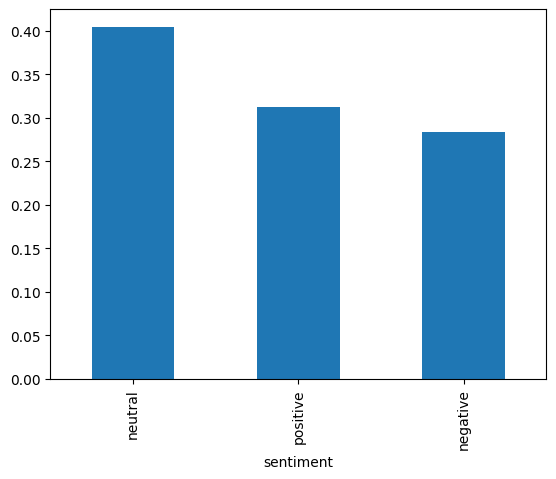

In [6]:
df['sentiment'].value_counts(normalize=True).plot(kind='bar');

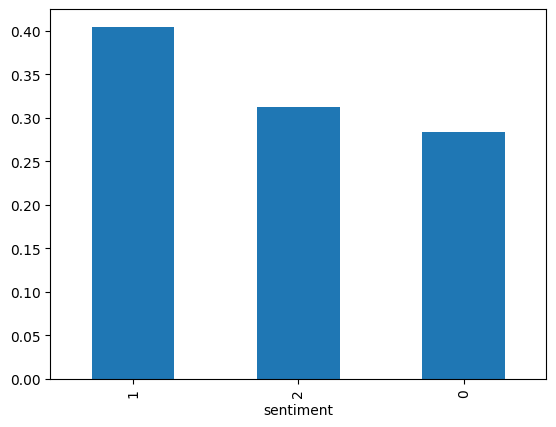

In [7]:
# Convert sentiment column to categorical variable
df['sentiment'] = df['sentiment'].astype('category').cat.codes
df['sentiment'].value_counts(normalize=True).plot(kind='bar');

In [8]:
# Convert Time of Tweet column to categorical variable
df['Time of Tweet'] = df['Time of Tweet'].astype('category').cat.codes
# Convert Country column to categorical variable
df['Country'] = df['Country'].astype('category').cat.codes
# convert Age of User to integer 
df['Age of User']=df['Age of User'].replace({'0-20':18,'21-30':25,'31-45':38,'46-60':53,'60-70':65,'70-100':80})

## Drop unuseful data

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 27480 entries, 0 to 27480
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   textID            27480 non-null  object 
 1   text              27480 non-null  object 
 2   selected_text     27480 non-null  object 
 3   sentiment         27480 non-null  int8   
 4   Time of Tweet     27480 non-null  int8   
 5   Age of User       27480 non-null  int64  
 6   Country           27480 non-null  int16  
 7   Population -2020  27480 non-null  float64
 8   Land Area (Km²)   27480 non-null  float64
 9   Density (P/Km²)   27480 non-null  float64
dtypes: float64(3), int16(1), int64(1), int8(2), object(3)
memory usage: 1.8+ MB


In [10]:
df.drop(columns=['textID','Time of Tweet', 'Age of User', 'Country', 'Population -2020', 'Land Area (Km²)', 'Density (P/Km²)'])

,text,selected_text,sentiment
0,"I`d have responded, if I were going","I`d have responded, if I were going",1
1,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,0
2,my boss is bullying me...,bullying me,0
3,what interview! leave me alone,leave me alone,0
4,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",0
...,...,...,...
27476,wish we could come see u on Denver husband l...,d lost,0
27477,I`ve wondered about rake to. The client has ...,", don`t force",0
27478,Yay good for both of you. Enjoy the break - y...,Yay good for both of you.,2
27479,But it was worth it ****.,But it was worth it ****.,2


## Creat a function to process text

In [11]:
def wp(text):
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub("\\W"," ",text) 
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)    
    return text

In [12]:
df['selected_text'] = df["selected_text"].apply(wp)

## Split data

In [13]:
X=df['selected_text']
y= df['sentiment']

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(21984,)
(5496,)
(21984,)
(5496,)


## Convert text to vectors

In [15]:
vectorization = TfidfVectorizer()
XV_train = vectorization.fit_transform(X_train)
XV_test = vectorization.transform(X_test)

## Baseline model

In [16]:
score_baseline = df['sentiment'].value_counts(normalize=True).max()
score_baseline

0.40454876273653567

## Logistic regression

In [17]:
lr = LogisticRegression(n_jobs=-1)
lr.fit(XV_train,y_train)

LogisticRegression(n_jobs=-1)

In [18]:
pred_lr=lr.predict(XV_test)

In [19]:
# get accuracy score
score_lr = accuracy_score(y_test, pred_lr)
score_lr

0.8309679767103348

In [20]:
print(classification_report(y_test, pred_lr))

              precision    recall  f1-score   support

           0       0.81      0.79      0.80      1572
           1       0.79      0.88      0.84      2236
           2       0.91      0.81      0.85      1688

    accuracy                           0.83      5496
   macro avg       0.84      0.82      0.83      5496
weighted avg       0.84      0.83      0.83      5496



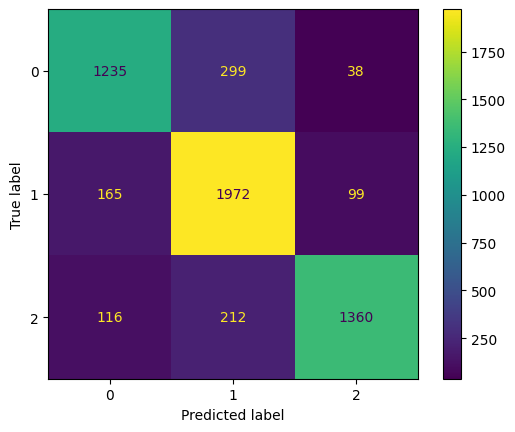

In [21]:
ConfusionMatrixDisplay.from_predictions(y_test, pred_lr);

## Decision Tree Classification

In [22]:
dt = DecisionTreeClassifier()
dt.fit(XV_train, y_train)

DecisionTreeClassifier()

In [23]:
pred_dt = dt.predict(XV_test)

In [24]:
score_dt = dt.score(XV_test, y_test)
score_dt

0.7641921397379913

In [25]:
print(classification_report(y_test, pred_dt))

              precision    recall  f1-score   support

           0       0.71      0.75      0.73      1572
           1       0.76      0.78      0.77      2236
           2       0.83      0.76      0.79      1688

    accuracy                           0.76      5496
   macro avg       0.77      0.76      0.76      5496
weighted avg       0.77      0.76      0.76      5496



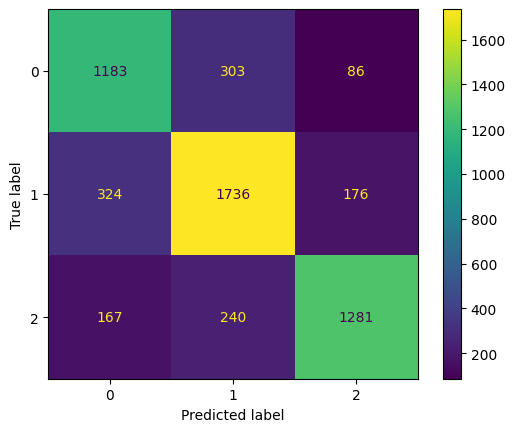

In [26]:
ConfusionMatrixDisplay.from_predictions(y_test, pred_dt);

## Random Forest Classifier

In [27]:
rfc = RandomForestClassifier(random_state=0)
rfc.fit(XV_train, y_train)

RandomForestClassifier(random_state=0)

In [28]:
pred_rfc = rfc.predict(XV_test)

In [29]:
score_rfc = rfc.score(XV_test, y_test)
score_rfc

0.8138646288209607

In [30]:
print(classification_report(y_test, pred_rfc))

              precision    recall  f1-score   support

           0       0.79      0.76      0.77      1572
           1       0.77      0.90      0.83      2236
           2       0.92      0.76      0.83      1688

    accuracy                           0.81      5496
   macro avg       0.83      0.80      0.81      5496
weighted avg       0.82      0.81      0.81      5496



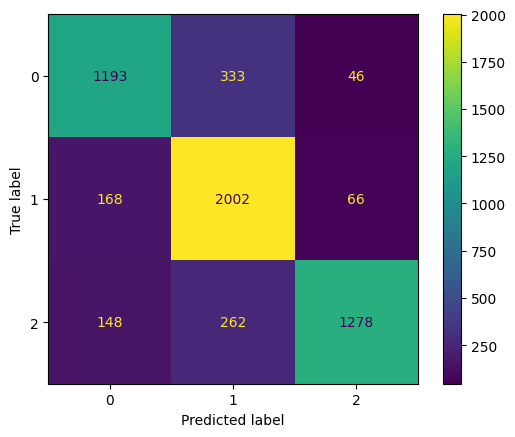

In [31]:
ConfusionMatrixDisplay.from_predictions(y_test, pred_rfc);

## Best model in accuracy 

In [32]:
print(f'Baseline model:{score_baseline} \nLogistic regression {score_lr}\nDecision Tree Classification {score_dt}\nRandim Forest Classifier {score_rfc}')

Baseline model:0.40454876273653567 
Logistic regression 0.8309679767103348
Decision Tree Classification 0.7641921397379913
Randim Forest Classifier 0.8138646288209607


# Communicate the result 

In [33]:
def output_lable(n):
    if n == 0:
        return "The Text Sentement is Negative"
    elif n == 1:
        return "The Text Sentement is Neutral"
    elif n == 2:
        return "The Text Sentement is Positive"
    
def manual_testing(news):
    testing_news = {"text":[news]}
    new_def_test = pd.DataFrame(testing_news)
    new_def_test["text"] = new_def_test["text"].apply(wp) 
    new_x_test = new_def_test["text"]
    new_xv_test = vectorization.transform(new_x_test)
    pred_lr = lr.predict(new_xv_test)
    pred_dt = dt.predict(new_xv_test)
    pred_rfc = rfc.predict(new_xv_test)

    return print((output_lable(pred_lr[0])))

In [34]:
# enter a text to find if its sentiment
text = str(input())
manual_testing(text)

StdinNotImplementedError: raw_input was called, but this frontend does not support input requests.